In [26]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from copy import deepcopy
from functools import wraps
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection


In [ ]:
# Import our modules

import fmm_functions as fmm
from quadtree import QuadTree, Particle

# Visualize the Quadtree

In [50]:
def reset_particles(particles):
    for p in particles:
        p.phi = 0

def plot_quadtree(n, tree_threshold):

    particles = [Particle(*p, 1) for p in np.random.rand(n,2)]
    tree = fmm.build_tree(particles, tree_threshold=tree_threshold)

    fig, ax = plt.subplots(1, figsize=(15, 10))
    pos = np.array([p.pos for p in particles])
    pc = PatchCollection([Rectangle((p.x0,p.y0), p.w, p.h) for p in tree.root.traverse()], facecolors='none', edgecolors='c', linewidth=2, alpha=.3)
    ax.set_title(f'Quadtree with {n} Particles and Threshold = {tree_threshold}', fontsize=25)
    ax.add_collection(pc)
    ax.scatter(pos[:,0], pos[:,1], c='m',marker='.')
    plt.axis('off')
    plt.show()

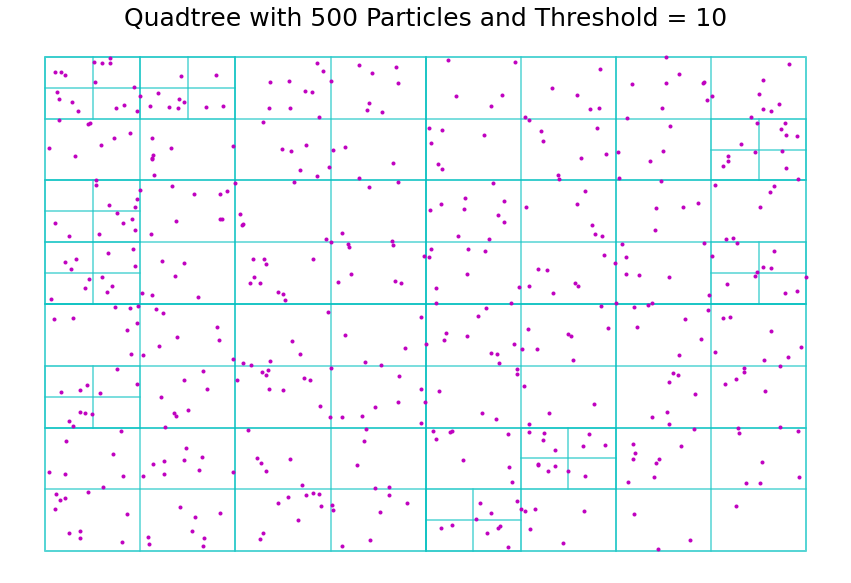

In [20]:
plot_quadtree(500, 10)

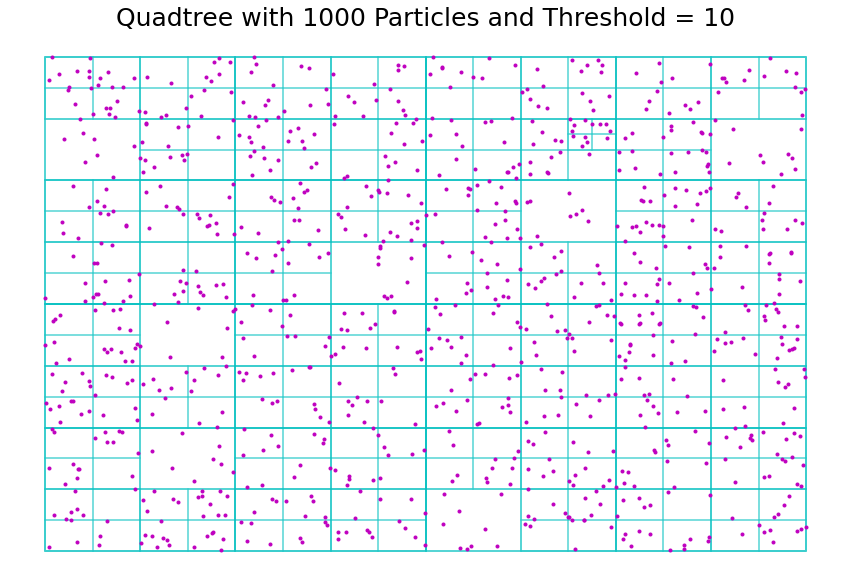

In [21]:
plot_quadtree(1000, 10)

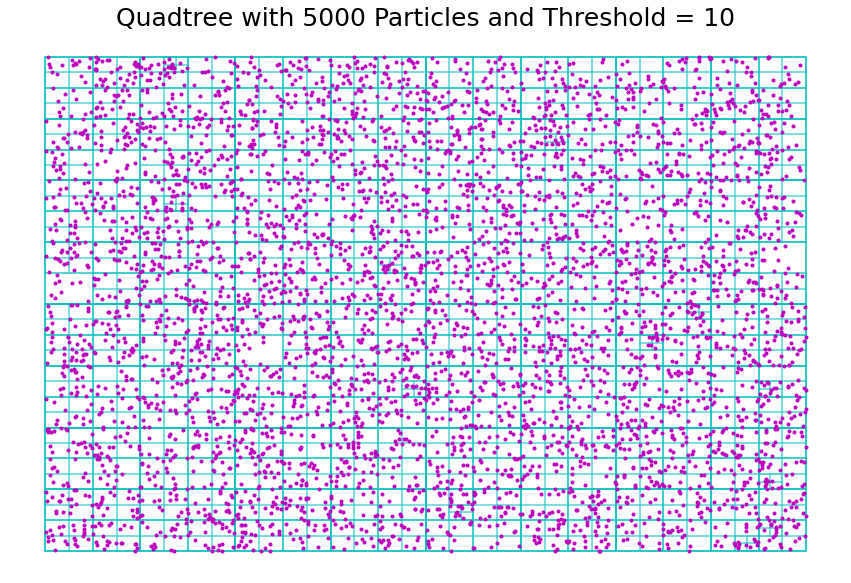

In [22]:
plot_quadtree(5000, 10)

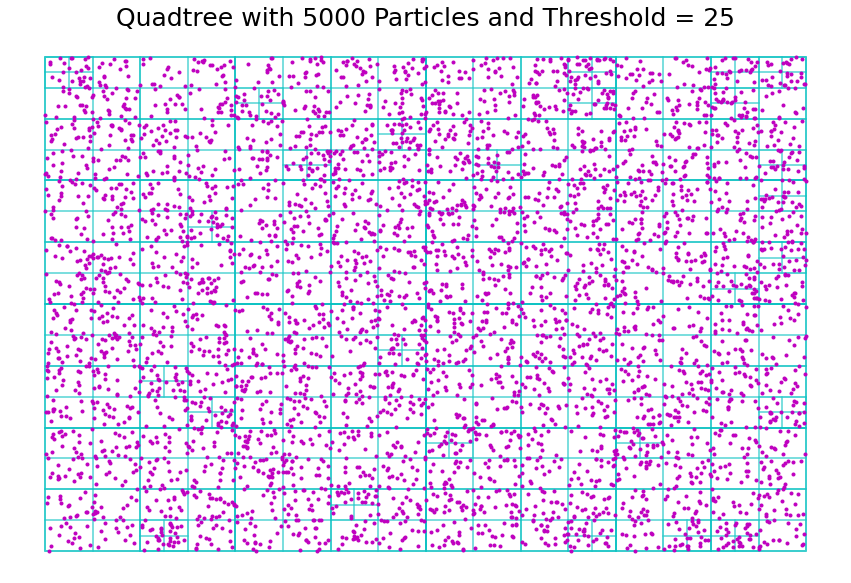

In [23]:
plot_quadtree(5000, 25)

# Check the accuracy compared to the direct sum

In [79]:
def plot_mape(n, rnd, tree_threshold=10, markersize=15):
    particles = [Particle(*p, 1) for p in np.random.rand(n,2)]
    particlesDS = deepcopy(particles)

    reset_particles(particles)
    reset_particles(particlesDS)

    fmm.potential_fmm(particles, nterms=30, tree_threshold=tree_threshold)
    phi = np.array([p.phi for p in particles])
    phiDS = fmm.potential_ds(particlesDS)

    fig, ax = plt.subplots(1, figsize=(15, 10))

    ax.set_xlabel('Particles', fontsize=20)
    ax.plot(phi, 'o', label='FMM', markersize=markersize)
    ax.plot(phiDS, 'x', label='Direct Sum', markersize=markersize)
    ax.legend(fontsize=15)
    ax.set_ylabel('Potential (Arbitrary Unit)', fontsize=20)

    ax2 = ax.twinx()
    ax2.plot(100*abs(phiDS - phi)/phiDS, color='peachpuff')
    ax2.set_ylabel('FMM Percent Error', fontsize=20)
    ax.set_title(f'With {n} particles and threshold={tree_threshold}: MAPE={np.round(np.mean(100*abs(phiDS - phi)/phiDS), rnd)}%', fontsize=25)

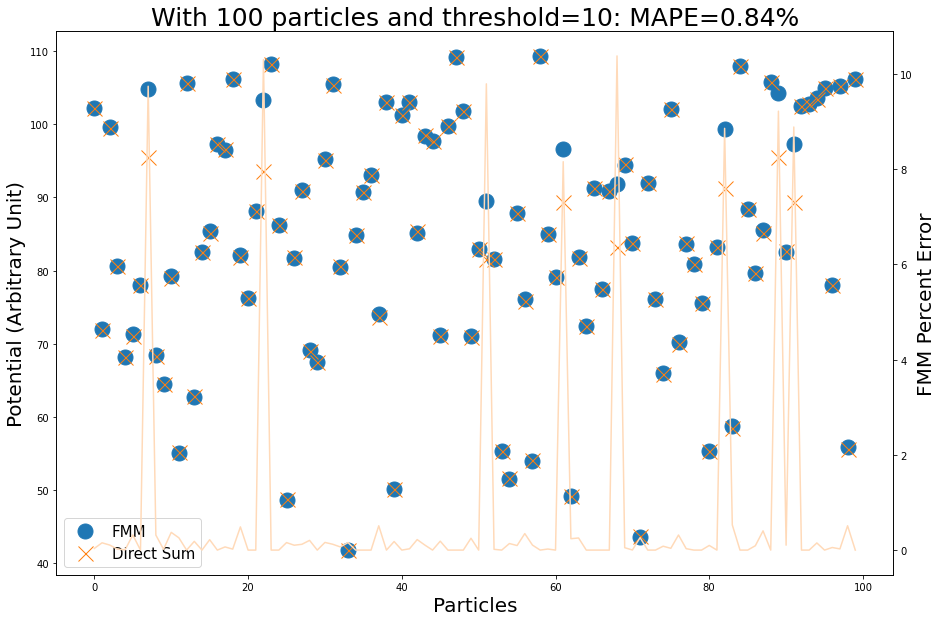

In [80]:
plot_mape(100, 2, 10, 15)

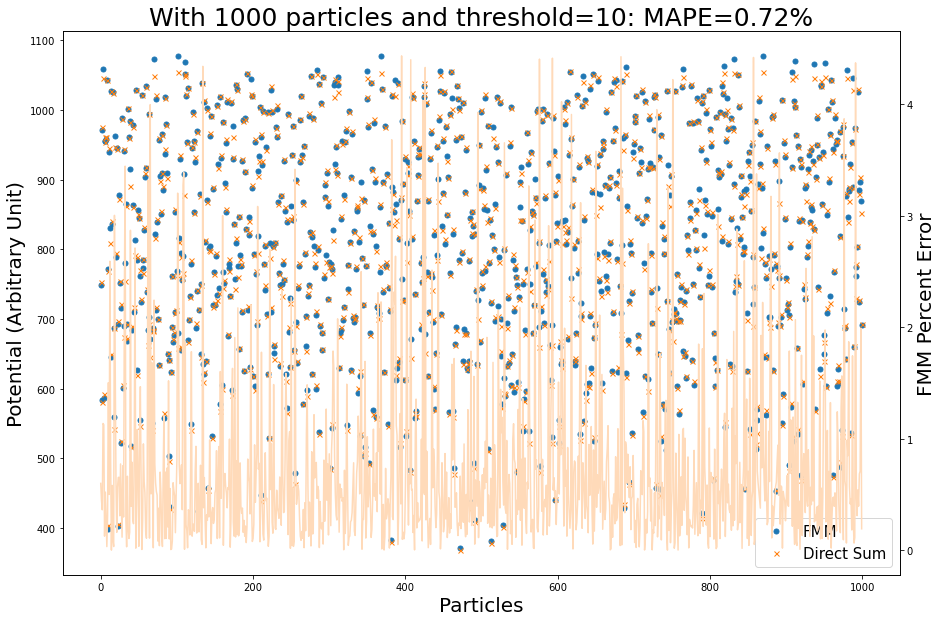

In [81]:
plot_mape(1000, 2, 10, 5)

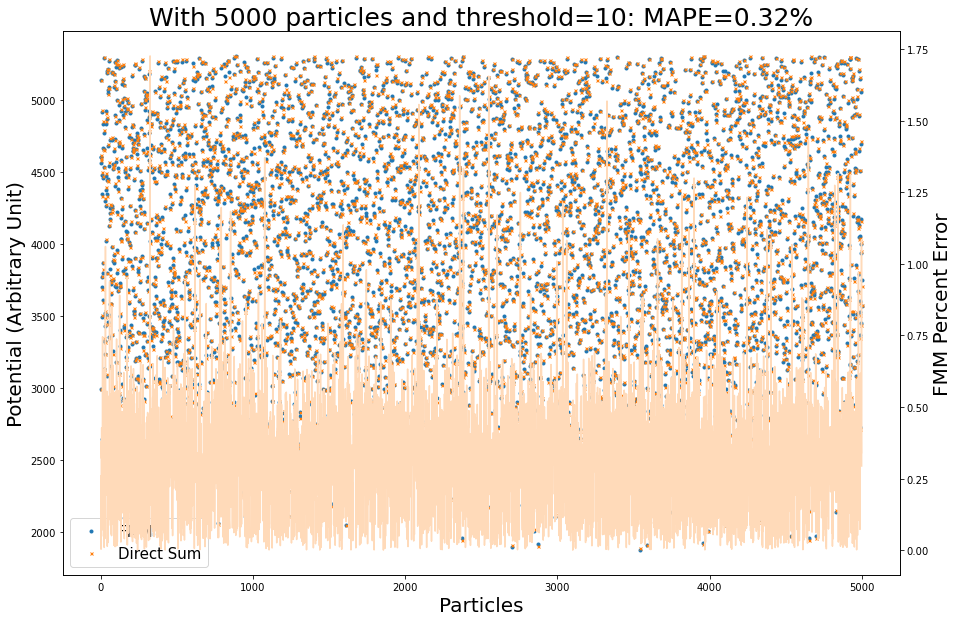

In [82]:
plot_mape(5000, 2, 10, 3)

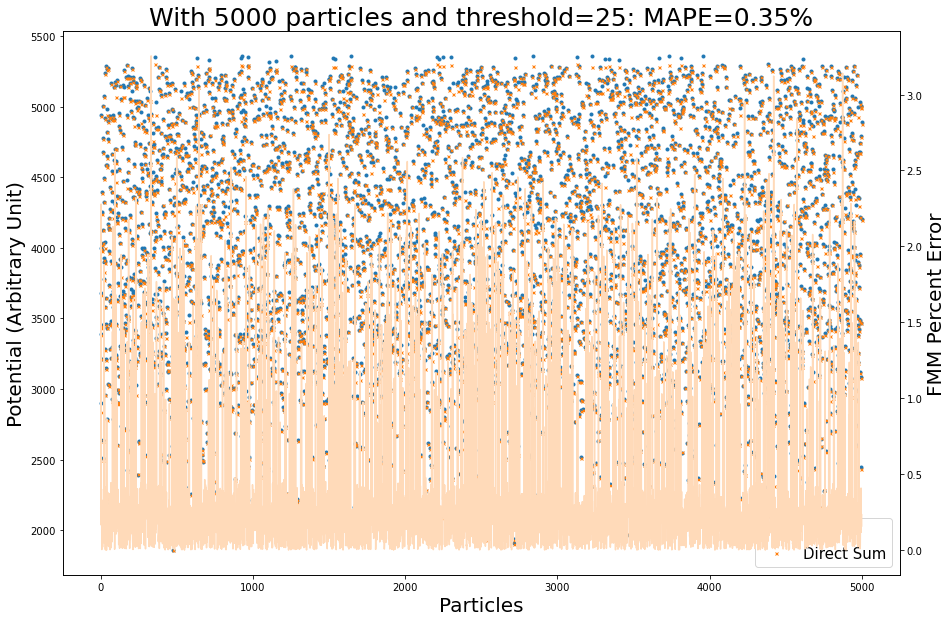

In [83]:
plot_mape(5000, 2, 25, 3)

# Scaling

In [124]:
def time_function(func, *args, **kwargs):
    @wraps(func)
    def tfunc(*args, **kwargs):
        start = time()
        res = func(*args, **kwargs)
        runtime = 1000*(time() - start)
        return runtime
    return tfunc

def plot_time(size):
    fmmtimed = time_function(fmm.potential_fmm)
    fmmprebuilt = time_function(fmm.potential_fmm_tree)
    directtimed = time_function(fmm.potential_ds)

    t_fmm = []
    t_direct = []

    pinit = lambda n: [Particle(*p, 1) for p in np.random.rand(n,2)]
    tinit = lambda n: fmm.build_tree(pinit(n), tree_threshold=n//10)

    t_fmm_prebuilt = list(map(fmmprebuilt, map(tinit, size)))
    t_fmm = list(map(fmmtimed, map(pinit, size)))
    t_direct = list(map(directtimed, map(pinit, size)))

    sizen = size/size[0]
    plt.figure(figsize=(15, 10))

    plt.semilogy(size, t_direct[0]*(sizen)**2, linewidth=3, color='blue')
    plt.semilogy(size, t_fmm_prebuilt[0]*sizen*np.log(np.e*sizen), linewidth=3, color='darkorange')
    plt.semilogy(size, t_fmm[0]*sizen, linewidth=3, color='forestgreen')
    plt.semilogy(size, t_fmm, 'o', markersize=10, color='red')
    plt.semilogy(size, t_fmm_prebuilt, 'o', markersize=10, color='darkturquoise')
    plt.semilogy(size, t_direct, 'o', markersize=10, color='darkviolet')

    plt.xticks(fontsize=15)
    plt.xlabel('Particles', fontsize=20)
    plt.yticks(fontsize=15)
    plt.ylabel('Runtime', fontsize=20)
    plt.legend([r'O(n$^2$)', 'O(nlog(n))', 'O(n)', 'FMM', 'FMM Prebuilt Tree', 'Direct Sum'], fontsize=15)
    
    plt.show()

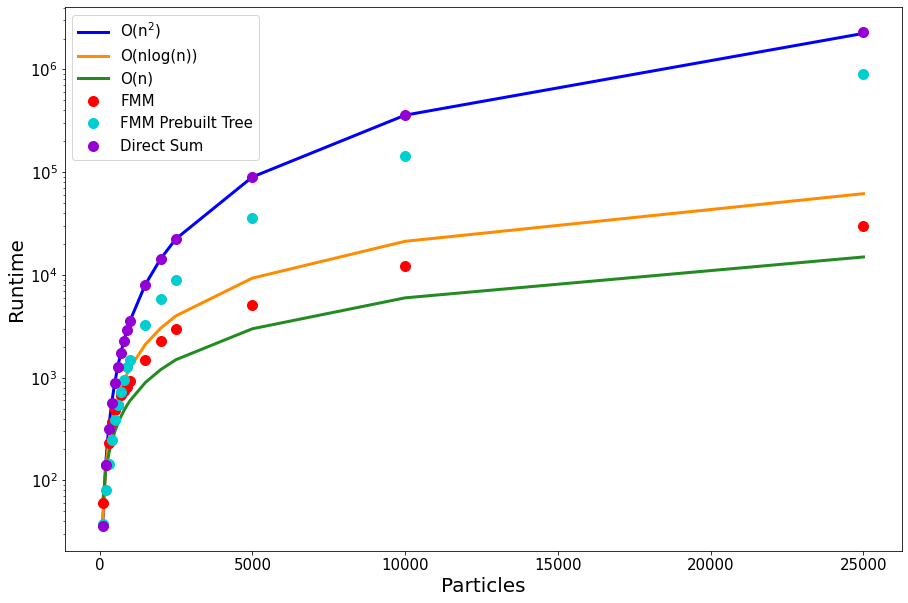

In [125]:
size = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500, 5000, 10000, 25000])

plot_time(size=size)